# Part 1

## import libraries

In [840]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap


In [841]:
import warnings 
warnings.filterwarnings('ignore')

In [842]:
df = pd.read_csv('Q1_data.csv')

In [843]:
df.head(5)

,Unnamed: 0,symbol,name,time_stamp,time_high,time_low,open,close,high,low,market_cap,volume
0,0,BTC,Bitcoin,2023-05-17T23:59:59.999Z,2023-05-17T20:09:00.000Z,2023-05-17T14:03:00.000Z,27035.470130,27398.802028,27465.927904,26600.144844,5.308901e+11,1.514001e+10
1,1,BTC,Bitcoin,2023-05-13T23:59:59.999Z,2023-05-13T18:50:00.000Z,2023-05-13T00:32:00.000Z,26807.769044,26784.078561,27030.482960,26710.873803,5.188737e+11,9.999172e+09
2,2,BTC,Bitcoin,2023-03-08T23:59:59.999Z,2023-03-08T00:23:00.000Z,2023-03-08T23:43:00.000Z,22216.442321,21718.079830,22268.896252,21708.050506,4.194214e+11,2.253658e+10
3,3,BTC,Bitcoin,2023-02-21T23:59:59.999Z,2023-02-21T08:30:00.000Z,2023-02-21T22:06:00.000Z,24833.048914,24436.354485,25126.851686,24200.364116,4.715777e+11,3.125210e+10
4,4,BTC,Bitcoin,2022-10-15T23:59:59.999Z,2022-10-15T03:59:00.000Z,2022-10-15T23:04:00.000Z,19185.437304,19067.635082,19212.541608,19019.250125,3.657224e+11,1.619224e+10


In [844]:
df['name'].unique()

array(['Bitcoin', 'BNB', 'Ethereum', 'Tether USDt'], dtype=object)

## Normalization Using StandardScaler

In [845]:
from sklearn.preprocessing import StandardScaler , MinMaxScaler
scaler = MinMaxScaler()
df_mm = df.copy()
df[['volume','market_cap']] = scaler.fit_transform(df[['volume','market_cap']])

Text(0, 0.5, 'Market Cap')

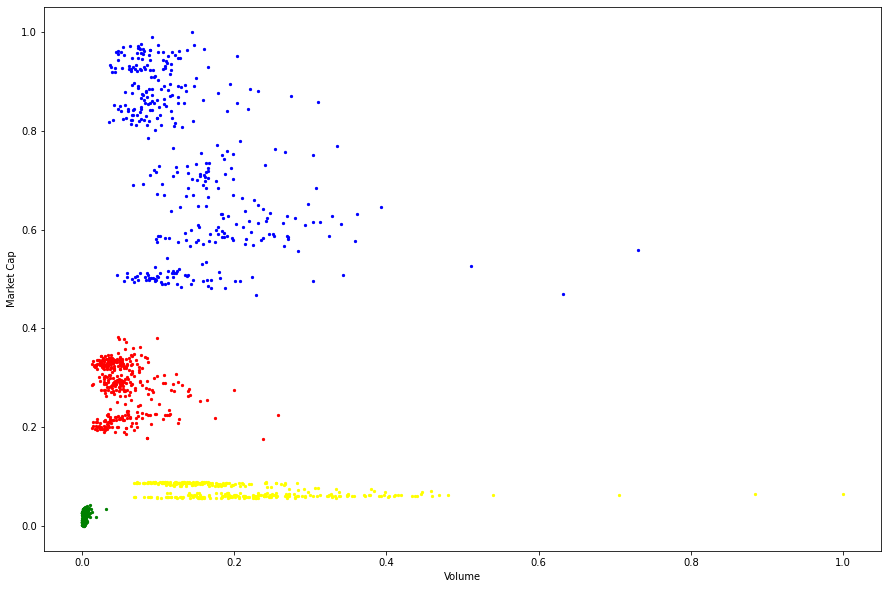

In [846]:
plt.figure(figsize=(15, 10))
plt.scatter(df[df['name'] == 'Bitcoin']['volume'], df[df['name'] == 'Bitcoin']['market_cap'], s=5, color='blue')
plt.scatter(df[df['name'] == 'BNB']['volume'], df[df['name'] == 'BNB']['market_cap'], s=5, color='green')
plt.scatter(df[df['name'] == 'Ethereum']['volume'], df[df['name'] == 'Ethereum']['market_cap'], s=5, color='red')
plt.scatter(df[df['name'] == 'Tether USDt']['volume'], df[df['name'] == 'Tether USDt']['market_cap'], s=5, color='yellow')
plt.xlabel('Volume')
plt.ylabel('Market Cap')

## 1-1 : KMeans Clustering

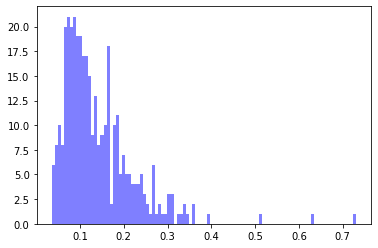

In [847]:
plt.hist(df[df['name'] == 'Bitcoin']['volume'], bins=100, color='blue', alpha=0.5)
plt.show()

In [848]:
#run kmeans clustering based on market cap and volume 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5 , n_init=100 )
kmeans.fit(df[['market_cap', 'volume']])
df['cluster'] = kmeans.predict(df[['market_cap', 'volume']])

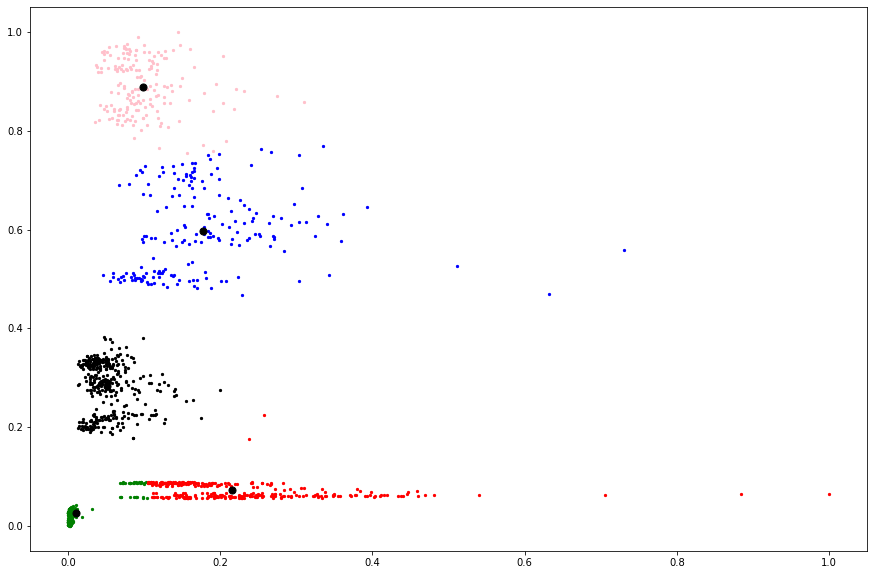

In [849]:
#plot the clusters
plt.figure(figsize=(15, 10))
plt.scatter(df[df['cluster'] == 0]['volume'], df[df['cluster'] == 0]['market_cap'], s=5, color='blue')
plt.scatter(df[df['cluster'] == 1]['volume'], df[df['cluster'] == 1]['market_cap'], s=5, color='green')
plt.scatter(df[df['cluster'] == 2]['volume'], df[df['cluster'] == 2]['market_cap'], s=5, color='red')
plt.scatter(df[df['cluster'] == 3]['volume'], df[df['cluster'] == 3]['market_cap'], s=5, color='pink')
plt.scatter(df[df['cluster'] == 4]['volume'], df[df['cluster'] == 4]['market_cap'], s=5, color='black')
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0], color='black', marker='o', s=50)
plt.show()

## 1-2 Finding Optimal K

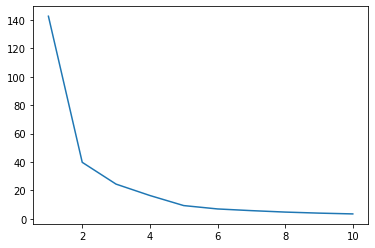

In [850]:
#run this for k =1 to k = 10 and calculate within cluster sum of squares
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df[['market_cap', 'volume']])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)

as you can see, elbow method can't help because of the shape of the graph. so we use silhouette method instead.

In [851]:
from sklearn.metrics import silhouette_score
K_range = range(2, 13)
silhouette_scores = []

for K in K_range:
    kmeans = KMeans(n_clusters=K)
    cluster_labels = kmeans.fit_predict(df_mm[['market_cap', 'volume']])
    silhouette_avg = silhouette_score(df_mm[['market_cap', 'volume']], cluster_labels)
    silhouette_scores.append(silhouette_avg)

optimal_K = K_range[silhouette_scores.index(max(silhouette_scores))]

print("Optimal K: ", optimal_K)

Optimal K:  4


Testing davies_bouldin_score

In [853]:
from sklearn.metrics import davies_bouldin_score
K_range = range(2, 11)
dbi_scores = []

for K in K_range:
    kmeans = KMeans(n_clusters=K)
    cluster_labels = kmeans.fit_predict(df_mm[['market_cap', 'volume']])
    dbi = davies_bouldin_score(df_mm[['market_cap', 'volume']], cluster_labels)
    dbi_scores.append(dbi)

# Find the K with the lowest Davies-Bouldin Index
optimal_K = K_range[np.argmin(dbi_scores)]
min_dbi = min(dbi_scores)
print(f"Optimal K according to Davies-Bouldin Index: {optimal_K}")
# print(f"Minimum Davies-Bouldin Index: {min_dbi}")

Optimal K according to Davies-Bouldin Index: 4


Testing GaussianMixture

In [854]:
from sklearn.mixture import GaussianMixture
K_range = range(2, 11)
bic_scores = []

for K in K_range:
    gmm = GaussianMixture(n_components=K)
    gmm.fit(df_mm[['market_cap', 'volume']])
    bic = gmm.bic(df_mm[['market_cap', 'volume']])
    bic_scores.append(bic)

optimal_K = K_range[np.argmin(bic_scores)]
min_bic = min(bic_scores)

print(f"Optimal K according to BIC: {optimal_K}")

Optimal K according to BIC: 10


<font color="red">TODO ^  Which one should we choose , <br> MAGHALE BIAR</font>


## 1-3 : Clustering with DBSCAN

### Normalization Using MinMaxScaler

In [855]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_mm[['volume','market_cap']] = scaler.fit_transform(df[['volume','market_cap']])

In [856]:
# dbscan = DBSCAN(eps=0.04, min_samples=15, metric='correlation')
# {'euclidean', 'precomputed', 'correlation', 'rogerstanimoto', 'canberra', 'sqeuclidean', 'nan_euclidean',
# 'seuclidean', 'wminkowski', 'sokalmichener', 'hamming', 'l1', 'russellrao', 'chebyshev', 
# 'cosine', 'sokalsneath', 'minkowski', 'cityblock', 'mahalanobis', 'manhattan', 'jaccard', 'haversine', 'kulsinski', 
# 'dice', 'yule', 'l2', 'matching', 'braycurtis'}

#dbscan = DBSCAN(eps=0.0366482344, min_samples=5, metric='chebyshev')


In [857]:
#run dbscan clustering based on market cap and volume
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.040, min_samples=5)
dbscan.fit(df_mm[['market_cap', 'volume']])
df_mm['cluster'] = dbscan.labels_
print(df_mm['cluster'].unique())
print((df_mm['cluster'] == -1).sum())

[ 0  1  2  3  4 -1]
21


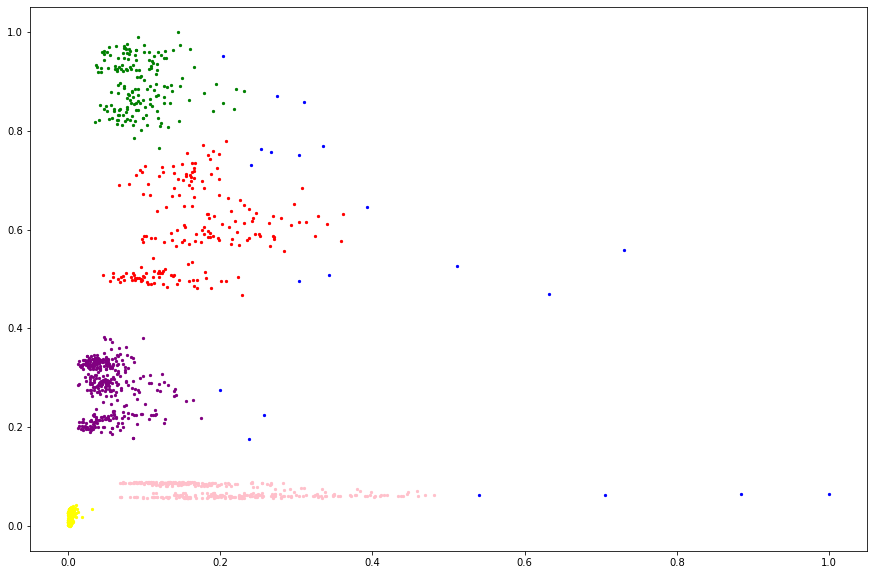

In [914]:
#plot the clusters
plt.figure(figsize=(15, 10))
plt.scatter(df_mm[df_mm['cluster'] == -1]['volume'], df_mm[df_mm['cluster'] == -1]['market_cap'], s=5, color='blue')
plt.scatter(df_mm[df_mm['cluster'] == 0]['volume'], df_mm[df_mm['cluster'] == 0]['market_cap'], s=5, color='green')
plt.scatter(df_mm[df_mm['cluster'] == 1]['volume'], df_mm[df_mm['cluster'] == 1]['market_cap'], s=5, color='red')
plt.scatter(df_mm[df_mm['cluster'] == 2]['volume'], df_mm[df_mm['cluster'] == 2]['market_cap'], s=5, color='yellow')
plt.scatter(df_mm[df_mm['cluster'] == 3]['volume'], df_mm[df_mm['cluster'] == 3]['market_cap'], s=5, color='purple')
plt.scatter(df_mm[df_mm['cluster'] == 4]['volume'], df_mm[df_mm['cluster'] == 4]['market_cap'], s=5, color='pink')
# plt.scatter(df_mm[df_mm['cluster'] == 5]['volume'], df_mm[df_mm['cluster'] == 5]['market_cap'], s=5, color='black')
plt.show()

## Even better 

### (By using `0.041` as `eps`)

In [925]:
#run dbscan clustering based on market cap and volume
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.043, min_samples=5)
dbscan.fit(df_mm[['market_cap', 'volume']])
df_mm['cluster'] = dbscan.labels_
df_mm['cluster'].unique()
print(df_mm['cluster'].unique())
print((df_mm['cluster'] == -1).sum())

[ 0  1  2  3 -1]
20


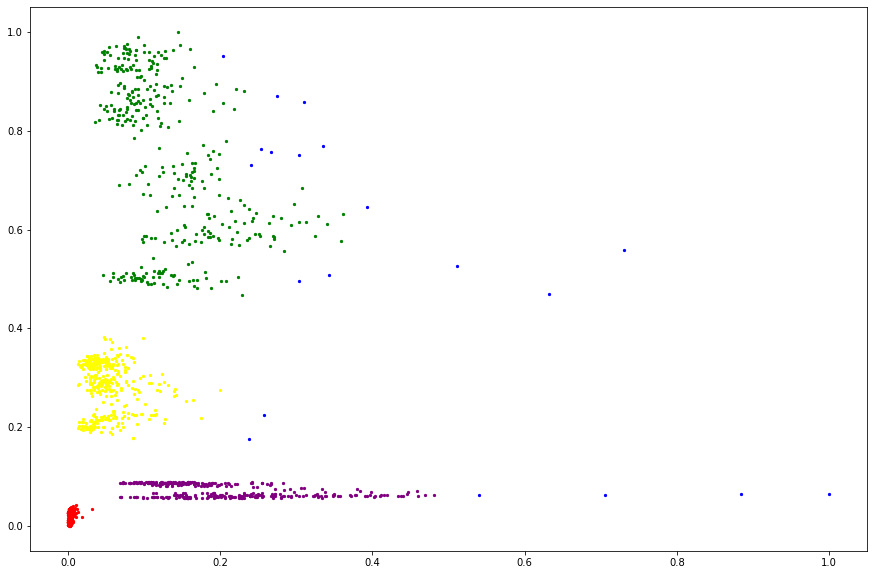

In [926]:
#plot the clusters
plt.figure(figsize=(15, 10))
plt.scatter(df_mm[df_mm['cluster'] == -1]['volume'], df_mm[df_mm['cluster'] == -1]['market_cap'], s=5, color='blue')
plt.scatter(df_mm[df_mm['cluster'] == 0]['volume'], df_mm[df_mm['cluster'] == 0]['market_cap'], s=5, color='green')
plt.scatter(df_mm[df_mm['cluster'] == 1]['volume'], df_mm[df_mm['cluster'] == 1]['market_cap'], s=5, color='red')
plt.scatter(df_mm[df_mm['cluster'] == 2]['volume'], df_mm[df_mm['cluster'] == 2]['market_cap'], s=5, color='yellow')
plt.scatter(df_mm[df_mm['cluster'] == 3]['volume'], df_mm[df_mm['cluster'] == 3]['market_cap'], s=5, color='purple')
plt.scatter(df_mm[df_mm['cluster'] == 4]['volume'], df_mm[df_mm['cluster'] == 4]['market_cap'], s=5, color='pink')


<font color="red">TO Know ^  Why this Works . </font>


# Part 2

In [358]:
df2 = pd.read_csv('coins_data.xlsx - Sheet1.csv')

In [359]:
df2.head(5)

,Symbol,Volume,MarketCap,TotalSupply,ProofType,Network
0,LEO,1.823284e+06,3586504072,"985,239,504",PoS,Ethereum
1,UNI,9.918768e+07,3992451215,"1,000,000,000",PoS,Ethereum
2,WBTC,1.415410e+08,4237575489,"163,106",PoW,Ethereum
3,AVAX,2.197065e+08,4901630273,"431,804,080",PoS,Avalanche
4,DAI,2.177113e+08,5513660644,"5,347,888,596",stablecoin,Ethereum


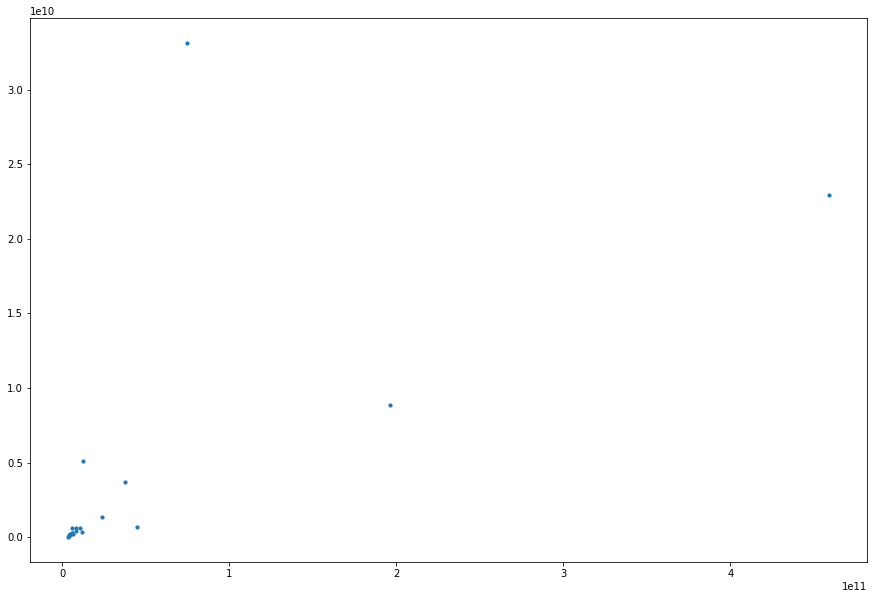

In [360]:
plt.figure(figsize=(15, 10))
plt.scatter(df2['MarketCap'], df2['Volume'] , s=10)

### 2-1 : Hierarchical Clustering

### Normalization Using StandardScaler

In [361]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df2[['Volume','MarketCap']] = scaler.fit_transform(df2[['Volume','MarketCap']])

### Calculating the linkage matrix

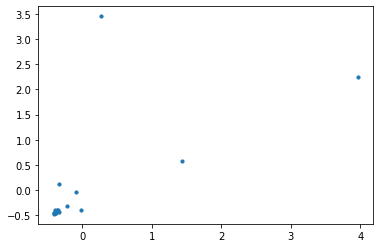

In [362]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# pairwise distances between data points
distances = pdist(df2[['MarketCap', 'Volume']], metric='euclidean')
square_distances = squareform(distances)
plt.scatter(df2['MarketCap'], df2['Volume'] , s=10 )

In [363]:
condensed_distances = squareform(square_distances)
linkage_matrix = linkage(condensed_distances, method='average')

### Plotting the dendrogram

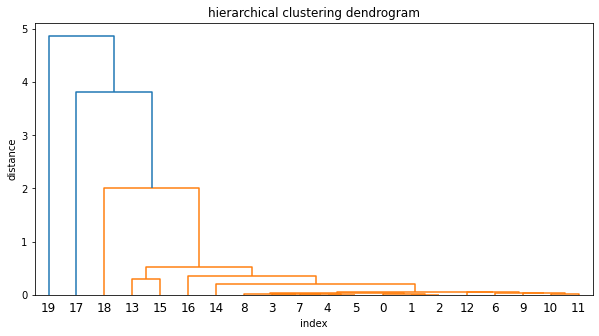

In [364]:
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=df2.index)
plt.xlabel('index')
plt.ylabel('distance')
plt.title('hierarchical clustering dendrogram')
plt.show()

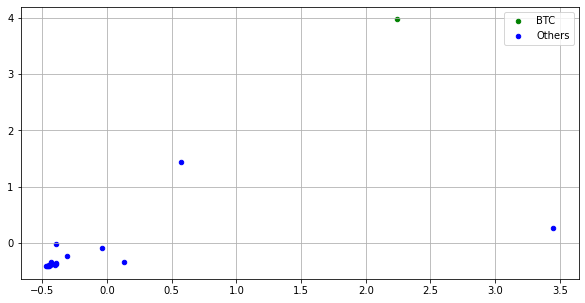

In [365]:
cluster_assignments = fcluster(linkage_matrix, t=4, criterion='distance')
# print(cluster_assignments)
df2['Cluster'] = cluster_assignments
#plot the clusters
plt.figure(figsize=(10, 5))
plt.scatter(df2[df2['Cluster'] == 2]['Volume'], df2[df2['Cluster'] == 2]['MarketCap'], s=20, color='green' , label=df2.iloc[-1]['Symbol'])
plt.scatter(df2[df2['Cluster'] == 1]['Volume'], df2[df2['Cluster'] == 1]['MarketCap'], s=20, color='blue' , label='Others')
plt.grid(True)
plt.legend()
df2.drop('Cluster' , axis=1, inplace=True)

In [366]:
# #make a 3d plot for volume, market cap and prooftype
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure(figsize=(15, 10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(df2['Volume'], df2['MarketCap'], df2['ProofType'], s=5)
# ax.set_xlabel('Volume')
# ax.set_ylabel('Market Cap')
# ax.set_zlabel('ProofType')
# plt.show()


## 2-2 : Adding `ProofType` to the data

### Using label encoder to encode `ProofType`

In [367]:
# now cluster based on volume, market cap and proof type using dendogram
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df2['ProofType'] = encoder.fit_transform(df2['ProofType'])

### Calculating the linkage matrix and plotting the dendrogram

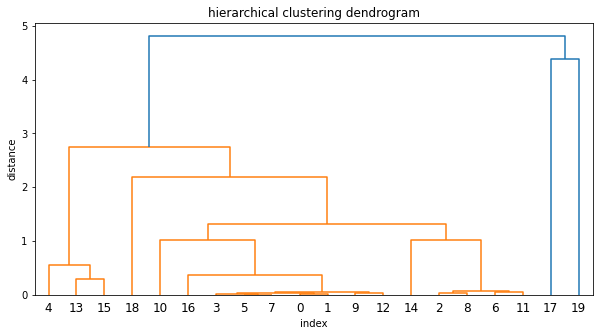

In [930]:
# now do the clustering
distances = pdist(df2[['MarketCap', 'Volume', 'ProofType']], metric='euclidean')
square_distances = squareform(distances)
# plt.scatter(df2['MarketCap'], df2['Volume'])
condensed_distances = squareform(square_distances)
linkage_matrix = linkage(condensed_distances, method='average')
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=df2.index)
plt.xlabel('index')
plt.ylabel('distance')
plt.title('hierarchical clustering dendrogram')
plt.show()

<font color="red">TODO ^ , is it important to use squareform twice ? <br> ARE </font>


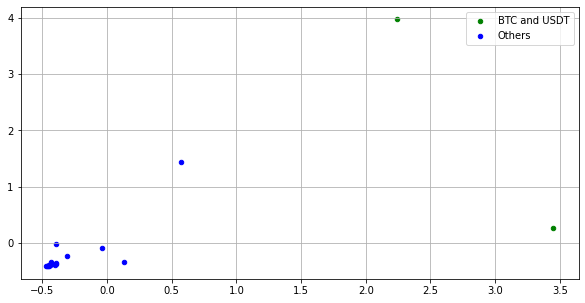

In [931]:
cluster_assignments = fcluster(linkage_matrix, t=4.5, criterion='distance')
df2['Cluster'] = cluster_assignments
#plot the clusters
plt.figure(figsize=(10, 5))
plt.scatter(df2[df2['Cluster'] == 2]['Volume'], df2[df2['Cluster'] == 2]['MarketCap'], s=20, color='green' , label=df2.iloc[19]['Symbol']+" and "+df2.iloc[17]['Symbol'] )
plt.scatter(df2[df2['Cluster'] == 1]['Volume'], df2[df2['Cluster'] == 1]['MarketCap'], s=20, color='blue' , label='Others')
plt.grid(True)
plt.legend()
df2.drop('Cluster' , axis=1, inplace=True)

## 2-3 : Adding more features to the data

In [932]:
encoder_n = LabelEncoder()
df2['Network'] = encoder_n.fit_transform(df2['Network'])

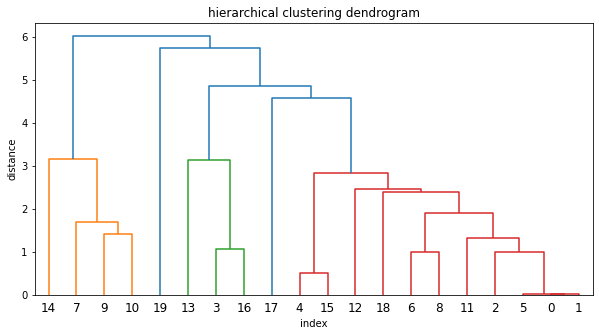

In [371]:
# now do the clustering
distances = pdist(df2[['MarketCap', 'Volume', 'ProofType' , 'Network']], metric='euclidean')
square_distances = squareform(distances)
# plt.scatter(df2['MarketCap'], df2['Volume'])
condensed_distances = squareform(square_distances)
linkage_matrix = linkage(condensed_distances, method='average')
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=df2.index)
plt.xlabel('index')
plt.ylabel('distance')
plt.title('hierarchical clustering dendrogram')
plt.show()

In [372]:
cluster_assignments = fcluster(linkage_matrix, t=5.8, criterion='distance')
df2['Cluster'] = cluster_assignments

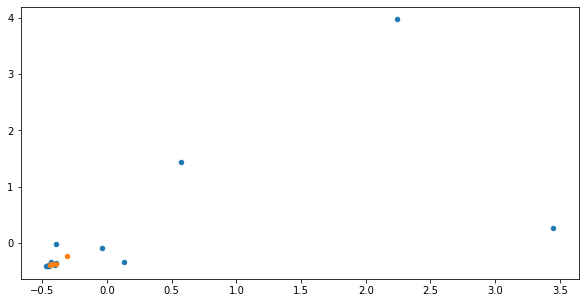

In [373]:
plt.figure(figsize=(10, 5))
for i in df2['Cluster'].unique():
    plt.scatter(df2[df2['Cluster'] == i]['Volume'], df2[df2['Cluster'] == i]['MarketCap'], s=20, label=i)



<font color="red">TODO ^ <br> 3d plot rasm she , additional feature </font>


# Part 3

In [934]:
import pandas as pd

In [935]:
df_hash = pd.read_csv('XMR_hash.csv')
df_hash.drop('Unnamed: 0' , axis=1 , inplace=True)
df_hash.drop('time_stamp' , axis=1 , inplace=True)
df_hash['Date'] = pd.to_datetime(df_hash['time']).dt.date
df_hash.drop('time' , axis=1 , inplace=True)
df_hash = df_hash.set_index('Date')
df_hash.index = pd.to_datetime(df_hash.index)
df_hash = df_hash[(df_hash.index >= '2017-11-09') & (df_hash.index <= '2023-10-07')]
df_hash = df_hash.groupby(df_hash.index).first()

In [936]:
df_hash

,hash
Date,
2017-11-09,2.338989e+08
2017-11-10,2.337782e+08
2017-11-11,2.337782e+08
2017-11-12,2.337782e+08
2017-11-13,2.337782e+08
...,...
2023-10-03,2.998112e+09
2023-10-04,2.732839e+09
2023-10-05,2.838379e+09


In [937]:
df_dif = pd.read_csv('XMR_difficulty.csv')
df_dif.drop('Unnamed: 0' , axis=1 , inplace=True)
df_dif.drop('time_stamp' , axis=1 , inplace=True)
df_dif['Date'] = pd.to_datetime(df_dif['time']).dt.date
df_dif.drop('time' , axis=1 , inplace=True)
df_dif = df_dif.set_index('Date')
df_dif.index = pd.to_datetime(df_dif.index)
df_dif = df_dif[(df_dif.index >= '2017-11-09') & (df_dif.index <= '2023-10-07')]
df_dif = df_dif.groupby(df_dif.index).first()

In [938]:
df_dif

,difficulty
Date,
2017-11-09,2.806786e+10
2017-11-10,2.805339e+10
2017-11-11,2.805339e+10
2017-11-12,2.805339e+10
2017-11-13,2.805339e+10
...,...
2023-10-03,3.597734e+11
2023-10-04,3.279407e+11
2023-10-05,3.406055e+11


In [939]:
import yfinance as yf

xmr = yf.Ticker("XMR-USD")
df_xmr = yf.download(tickers = "XMR-USD",period = "max",interval = "1d")
df_btc = yf.download(tickers="BTC-USD", period="max", interval="1d")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Dropping `Afj Close` as it was already in Close column

In [940]:
df_xmr.drop('Adj Close' , axis=1 , inplace=True)
df_btc.drop('Adj Close' , axis=1 , inplace=True)

In [941]:
df_xmr = df_xmr[(df_xmr.index >= '2017-11-09') & (df_xmr.index <= '2023-10-07')]
df_xmr

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-09,112.531998,123.404999,112.219002,120.779999,86864600
2017-11-10,121.344002,121.665001,101.757004,105.585999,84614000
2017-11-11,105.750000,127.106003,103.877998,119.615997,107708000
2017-11-12,119.597000,133.675003,110.617996,123.856003,144948000
2017-11-13,128.960007,136.528000,120.921997,123.402000,116200000
...,...,...,...,...,...
2023-10-03,146.193024,147.805603,145.165909,147.151352,49389643
2023-10-04,147.168442,150.702347,145.940781,150.469055,59400400
2023-10-05,150.474197,151.328369,148.565491,149.623718,55704972


In [942]:
df_combined = pd.merge(df_xmr, df_btc, on="Date", how="inner")

Dropping datas after `2023-10-07`

In [943]:
df_combined.drop(df_combined[df_combined.index > '2023-10-07'].index, inplace=True)

In [944]:
df_combined

,Open_x,High_x,Low_x,Close_x,Volume_x,Open_y,High_y,Low_y,Close_y,Volume_y
Date,,,,,,,,,,
2017-11-09,112.531998,123.404999,112.219002,120.779999,86864600,7446.830078,7446.830078,7101.520020,7143.580078,3226249984
2017-11-10,121.344002,121.665001,101.757004,105.585999,84614000,7173.729980,7312.000000,6436.870117,6618.140137,5208249856
2017-11-11,105.750000,127.106003,103.877998,119.615997,107708000,6618.609863,6873.149902,6204.220215,6357.600098,4908680192
2017-11-12,119.597000,133.675003,110.617996,123.856003,144948000,6295.450195,6625.049805,5519.009766,5950.069824,8957349888
2017-11-13,128.960007,136.528000,120.921997,123.402000,116200000,5938.250000,6811.189941,5844.290039,6559.490234,6263249920
...,...,...,...,...,...,...,...,...,...,...
2023-10-03,146.193024,147.805603,145.165909,147.151352,49389643,27508.251953,27667.191406,27216.001953,27429.978516,11407814187
2023-10-04,147.168442,150.702347,145.940781,150.469055,59400400,27429.074219,27826.658203,27248.105469,27799.394531,11143355314
2023-10-05,150.474197,151.328369,148.565491,149.623718,55704972,27798.646484,28091.861328,27375.601562,27415.912109,11877253670


In [945]:
df_combined = pd.merge(df_combined, df_hash, on="Date", how="inner")
df_combined = pd.merge(df_combined, df_dif, on="Date", how="inner")

In [946]:
df_combined.drop(['Open_x','High_x','Low_x','Open_y','High_y','Low_y'] , axis=1 , inplace=True)

In [947]:
df_combined

,Close_x,Volume_x,Close_y,Volume_y,hash,difficulty
Date,,,,,,
2017-11-09,120.779999,86864600,7143.580078,3226249984,2.338989e+08,2.806786e+10
2017-11-10,105.585999,84614000,6618.140137,5208249856,2.337782e+08,2.805339e+10
2017-11-11,119.615997,107708000,6357.600098,4908680192,2.337782e+08,2.805339e+10
2017-11-12,123.856003,144948000,5950.069824,8957349888,2.337782e+08,2.805339e+10
2017-11-13,123.402000,116200000,6559.490234,6263249920,2.337782e+08,2.805339e+10
...,...,...,...,...,...,...
2023-10-03,147.151352,49389643,27429.978516,11407814187,2.998112e+09,3.597734e+11
2023-10-04,150.469055,59400400,27799.394531,11143355314,2.732839e+09,3.279407e+11
2023-10-05,149.623718,55704972,27415.912109,11877253670,2.838379e+09,3.406055e+11


## Labling the data

In [948]:
df_combined['Label'] = (df_combined['Close_x'].shift(-1) > df_combined['Close_x']).astype(int)

In [949]:
df_combined[['Close_x','Label']]

,Close_x,Label
Date,,
2017-11-09,120.779999,0
2017-11-10,105.585999,1
2017-11-11,119.615997,1
2017-11-12,123.856003,0
2017-11-13,123.402000,0
...,...,...
2023-10-03,147.151352,1
2023-10-04,150.469055,0
2023-10-05,149.623718,1


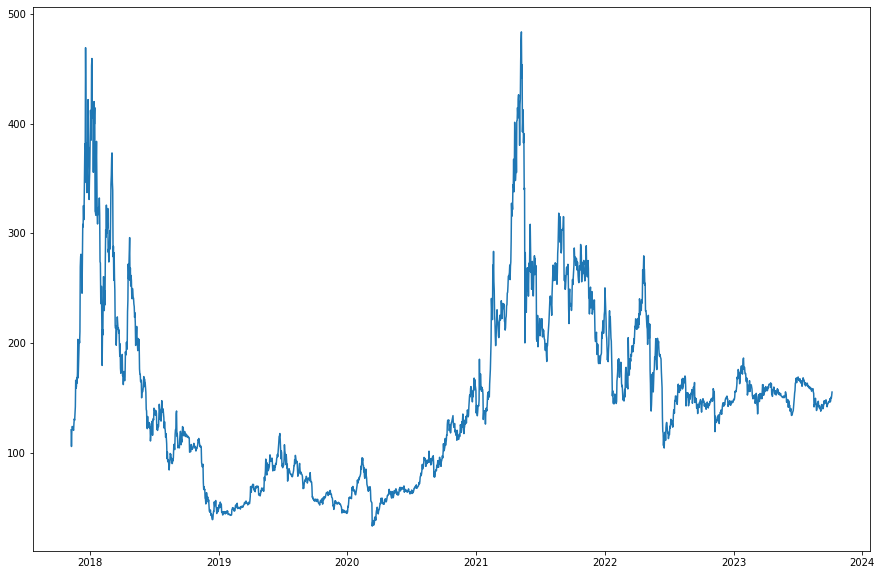

In [953]:
plt.figure(figsize=(15, 10))
plt.plot(df_xmr['Close'])
plt.show()

# mehrnaz ba too

## Normalization Using StandardScaler

In [954]:
from sklearn.preprocessing import StandardScaler , MinMaxScaler
scaler = StandardScaler()
df_combined[df_combined.columns[:-1]] = scaler.fit_transform(df_combined[df_combined.columns[:-1]])

In [955]:
df_combined

,Close_x,Volume_x,Close_y,Volume_y,hash,difficulty,Label
Date,,,,,,,
2017-11-09,-0.352803,-0.157013,-0.869556,-1.157004,-1.402161,-1.402448,0
2017-11-10,-0.540957,-0.159259,-0.902629,-1.052195,-1.402281,-1.402567,1
2017-11-11,-0.367217,-0.136213,-0.919028,-1.068036,-1.402281,-1.402567,1
2017-11-12,-0.314711,-0.099049,-0.944678,-0.853942,-1.402281,-1.402567,0
2017-11-13,-0.320333,-0.127738,-0.906320,-0.996407,-1.402281,-1.402567,0
...,...,...,...,...,...,...,...
2023-10-03,-0.026234,-0.194411,0.407317,-0.724361,1.342695,1.342759,1
2023-10-04,0.014851,-0.184421,0.430569,-0.738346,1.079280,1.079311,0
2023-10-05,0.004383,-0.188108,0.406432,-0.699537,1.184081,1.184125,1


## Checking if the data is balanced

In [956]:
df_combined['Label'].value_counts()

1    1126
0    1024
Name: Label, dtype: int64

In [957]:
# df_combined['Close_x'] = df_combined['Close_x']

In [958]:
df_combined

,Close_x,Volume_x,Close_y,Volume_y,hash,difficulty,Label
Date,,,,,,,
2017-11-09,-0.352803,-0.157013,-0.869556,-1.157004,-1.402161,-1.402448,0
2017-11-10,-0.540957,-0.159259,-0.902629,-1.052195,-1.402281,-1.402567,1
2017-11-11,-0.367217,-0.136213,-0.919028,-1.068036,-1.402281,-1.402567,1
2017-11-12,-0.314711,-0.099049,-0.944678,-0.853942,-1.402281,-1.402567,0
2017-11-13,-0.320333,-0.127738,-0.906320,-0.996407,-1.402281,-1.402567,0
...,...,...,...,...,...,...,...
2023-10-03,-0.026234,-0.194411,0.407317,-0.724361,1.342695,1.342759,1
2023-10-04,0.014851,-0.184421,0.430569,-0.738346,1.079280,1.079311,0
2023-10-05,0.004383,-0.188108,0.406432,-0.699537,1.184081,1.184125,1


## Train,Vaidation,Test Split

In [959]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , f1_score , classification_report , confusion_matrix
from sklearn.model_selection import GridSearchCV

In [960]:
test_data = df_combined[(df_combined.index >= '2023-09-08') & (df_combined.index <= '2023-10-07')]

In [961]:
# test data is from 08-09-2023 to 07-10-2023 , make it 
X_test = test_data.drop('Label' , axis=1).to_numpy()
y_test = test_data['Label'].to_numpy()
test_data.shape

(30, 7)

In [962]:
df_train = df_combined.drop(test_data.index , axis=0)
X = df_train.drop('Label' , axis=1).to_numpy()
y = df_train['Label'].to_numpy()

In [870]:
X_train , X_val , y_train , y_val = train_test_split( X, y ,
                                                     test_size=0.2,
                                                     shuffle=False )

## LogisticRegression

In [963]:
from sklearn.linear_model import LogisticRegression
ls = LogisticRegression()
ls.fit(X_train , y_train)

LogisticRegression()

### CV evaluation

In [964]:
y_pred = ls.predict(X_val)
print(classification_report(y_val , y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       190
           1       0.55      1.00      0.71       234

    accuracy                           0.55       424
   macro avg       0.28      0.50      0.36       424
weighted avg       0.30      0.55      0.39       424



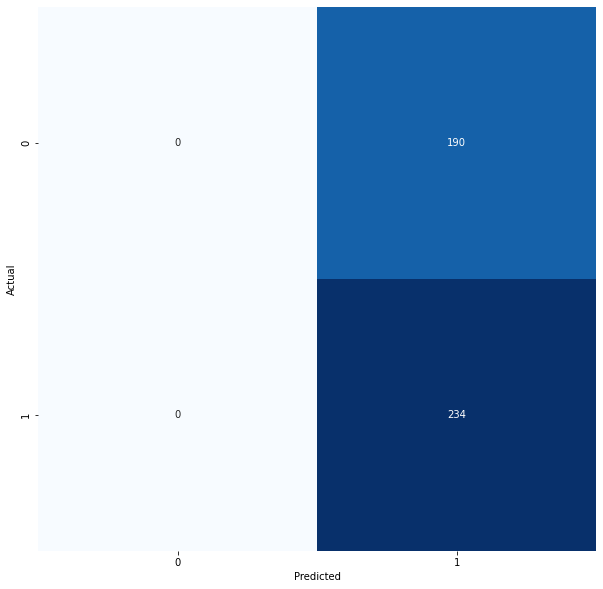

In [965]:
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Final results

In [966]:
y_pred_ls_final = ls.predict(X_test)
print(f1_score(y_test , y_pred_ls_final))
# print(classification_report(y_test , y_pred_ls_final ))

0.7234042553191489


In [875]:
cm = confusion_matrix(y_test, y_pred_ls_final)
cm

array([[ 0, 13],
       [ 0, 17]], dtype=int64)

## Random Forest Classifier

In [1005]:
# rf classifier
from sklearn.ensemble import RandomForestClassifier
# model_rf = RandomForestClassifier()
# param_grid = {
#     'n_estimators': [50, 100, 200],  
#     'max_features': ['log2', 'sqrt'], 
#     'max_depth': [ 10, 20, 30], 
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [2, 4],  
# }
# gs = GridSearchCV(model_rf , param_grid=param_grid , cv=3 , scoring='f1' , verbose=1)
# gs.fit(X_train , y_train )

In [1006]:
# Make 'Close' feature more important to the model
# model_rf = RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=50)
# model_rf.fit(X_train , y_train)

model_rf = RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=50)
model_rf.fit(X_train , y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=50)

In [1007]:
y_pred = model_rf.predict(X_val)
print(f1_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

0.6336996336996338
              precision    recall  f1-score   support

           0       0.46      0.27      0.34       190
           1       0.55      0.74      0.63       234

    accuracy                           0.53       424
   macro avg       0.50      0.50      0.49       424
weighted avg       0.51      0.53      0.50       424



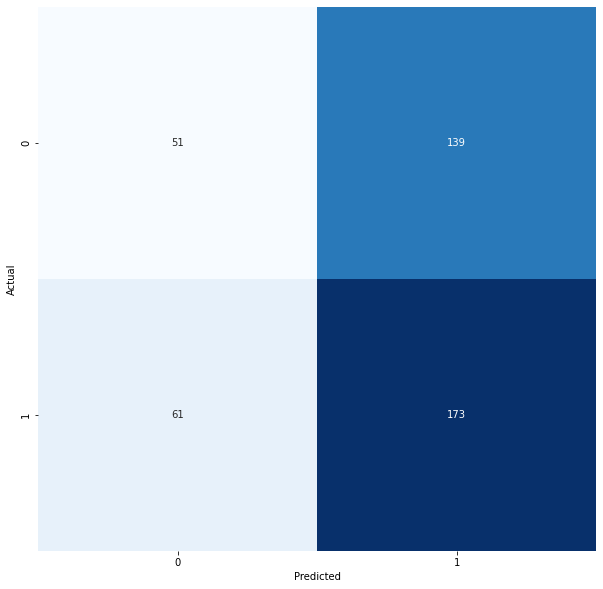

In [1008]:
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Final Results

In [1009]:
y_pred_rf_final = model_rf.predict(X_test)
print(f1_score(y_test, y_pred_rf_final))
print(classification_report(y_test, y_pred_rf_final))

0.744186046511628
              precision    recall  f1-score   support

           0       0.75      0.23      0.35        13
           1       0.62      0.94      0.74        17

    accuracy                           0.63        30
   macro avg       0.68      0.59      0.55        30
weighted avg       0.67      0.63      0.57        30



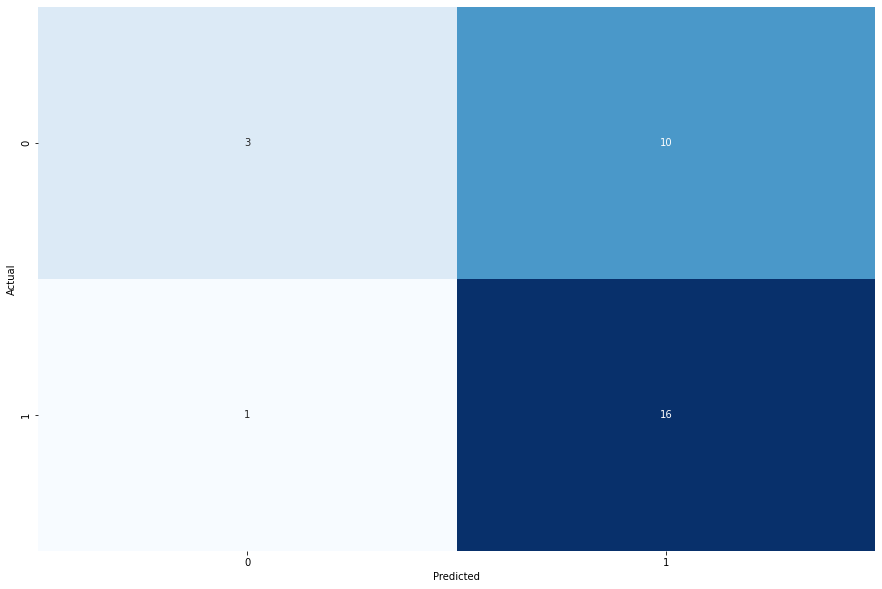

In [1010]:
plt.figure(figsize=(15, 10))
cm = confusion_matrix(y_test, y_pred_rf_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

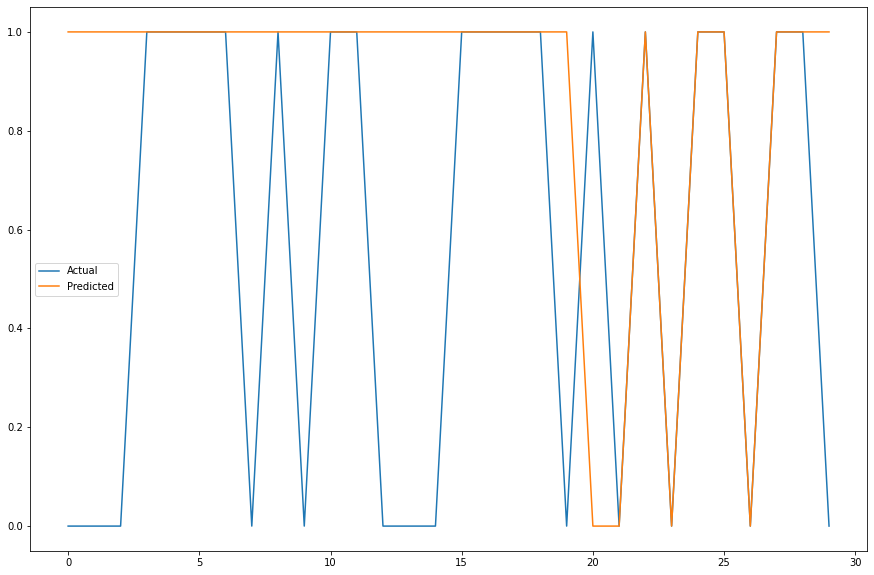

In [1011]:
# plot predictions vs actual
plt.figure(figsize=(15, 10))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_rf_final, label='Predicted')
plt.legend()
plt.show()

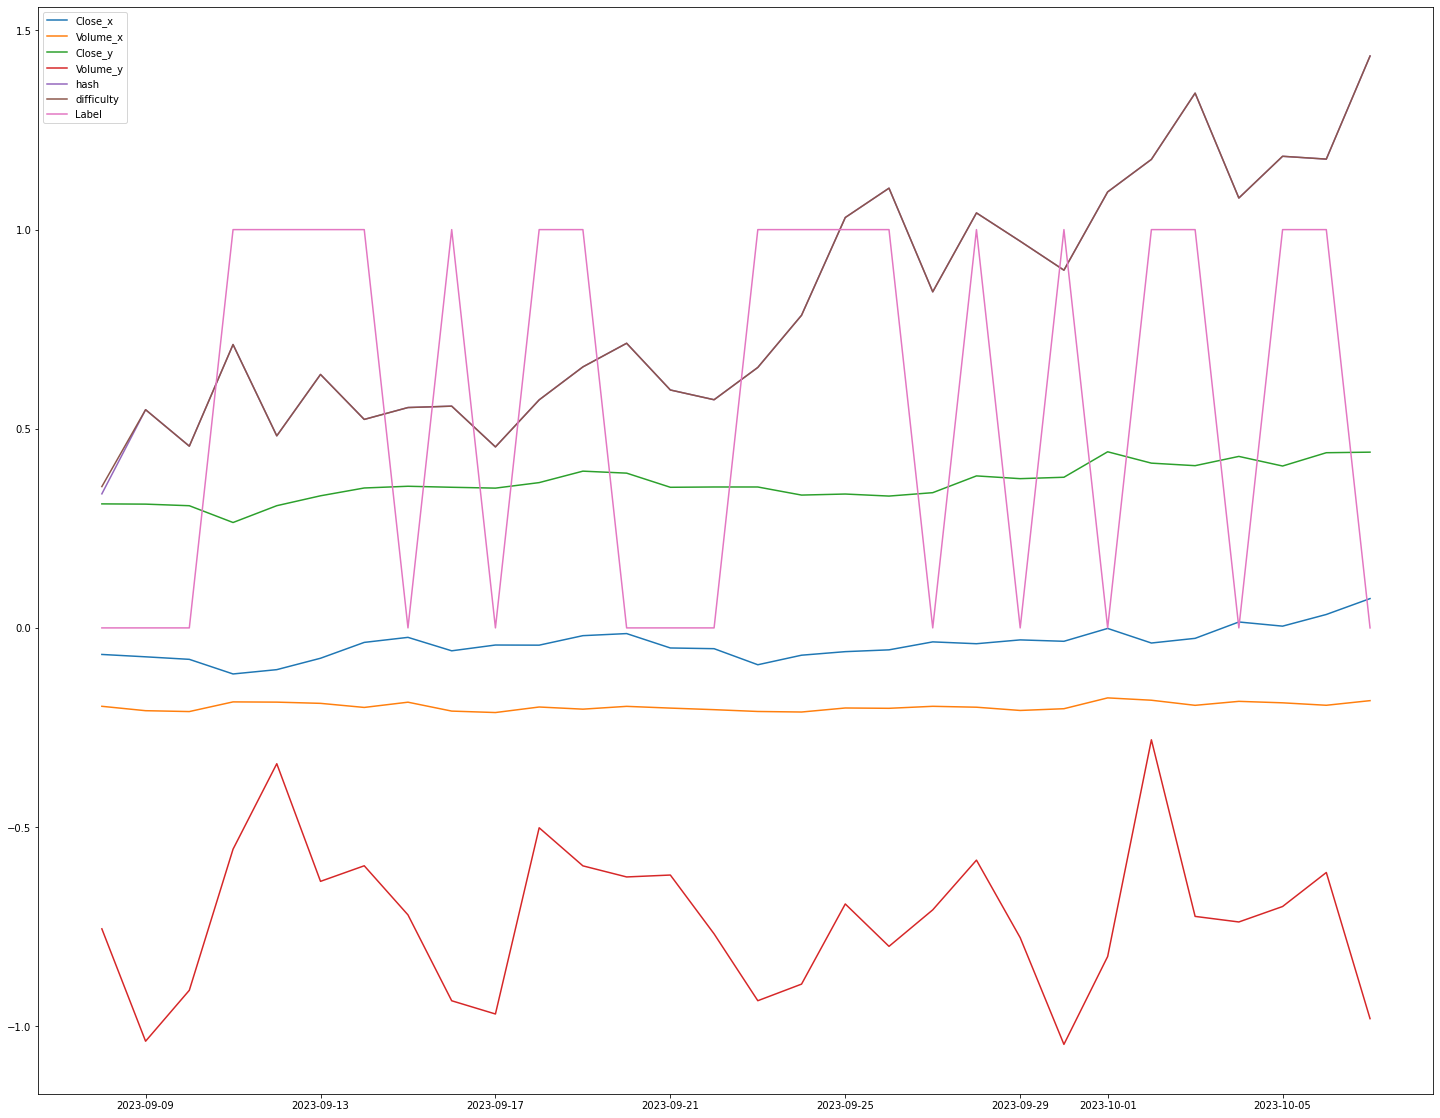

In [1012]:
plt.figure(figsize=(25, 20))
plt.plot(test_data)
plt.legend(test_data.columns)

## SVM

In [1120]:
# grid search for svc
from sklearn.svm import SVC
# model_svc = SVC()
# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'gamma': [1, 0.1, 0.01, 0.001],
#     'kernel': ['rbf', 'poly', 'sigmoid']
# }
# gs = GridSearchCV(model_svc , param_grid=param_grid , cv=3 , scoring='f1' , verbose=1)
# gs.fit(X_train , y_train)

In [1121]:
model_svm = SVC()
model_svm.fit(X_train , y_train)

SVC()

### CV evaluation

In [1122]:
print(f1_score(y_val, model_svm.predict(X_val)))
print(classification_report(y_val, model_svm.predict(X_val)))

0.6971608832807571
              precision    recall  f1-score   support

           0       0.46      0.06      0.10       190
           1       0.55      0.94      0.70       234

    accuracy                           0.55       424
   macro avg       0.51      0.50      0.40       424
weighted avg       0.51      0.55      0.43       424



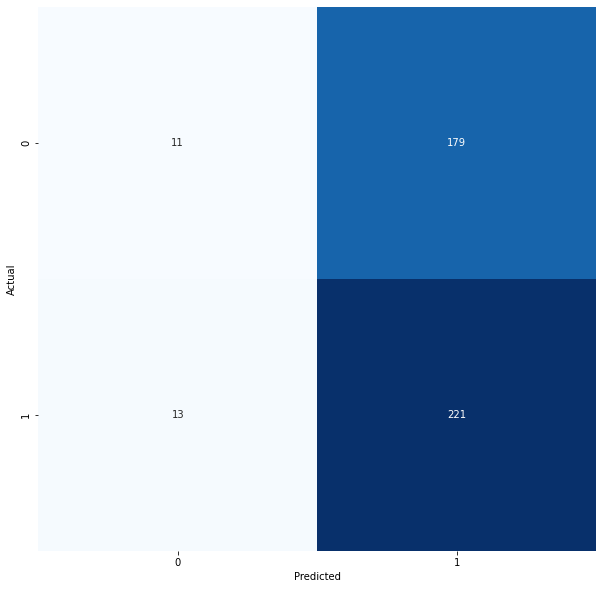

In [1123]:
cm = confusion_matrix(y_val, model_svm.predict(X_val))
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Final results

In [1124]:
print(f1_score(y_test, model_svm.predict(X_test)))
print(classification_report(y_test, model_svm.predict(X_test)))

0.7111111111111111
              precision    recall  f1-score   support

           0       0.50      0.08      0.13        13
           1       0.57      0.94      0.71        17

    accuracy                           0.57        30
   macro avg       0.54      0.51      0.42        30
weighted avg       0.54      0.57      0.46        30



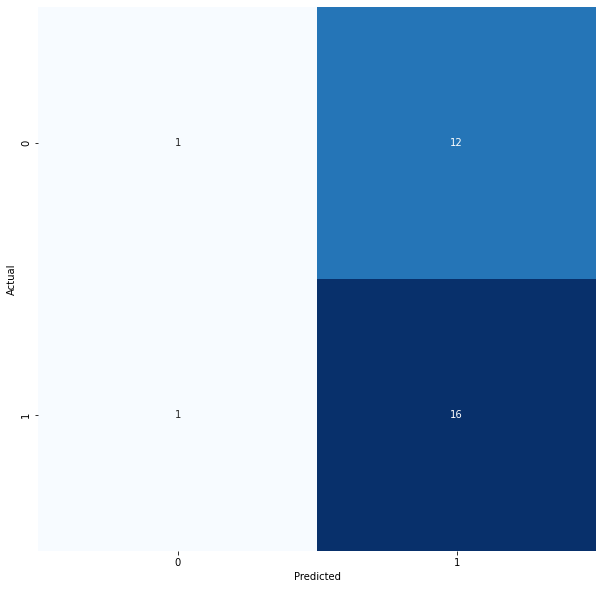

In [1127]:
cm = confusion_matrix(y_test, model_svm.predict(X_test))
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## KNN 

In [1126]:
# knn for this
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier()
model_knn.fit(X_train , y_train)


KNeighborsClassifier()

### CV evaluation

In [ ]:
print(f1_score(y_val, model_knn.predict(X_val)))
print(classification_report(y_val, model_knn.predict(X_val)))

0.5859872611464968
              precision    recall  f1-score   support

           0       0.49      0.48      0.48       190
           1       0.58      0.59      0.59       234

    accuracy                           0.54       424
   macro avg       0.53      0.53      0.53       424
weighted avg       0.54      0.54      0.54       424



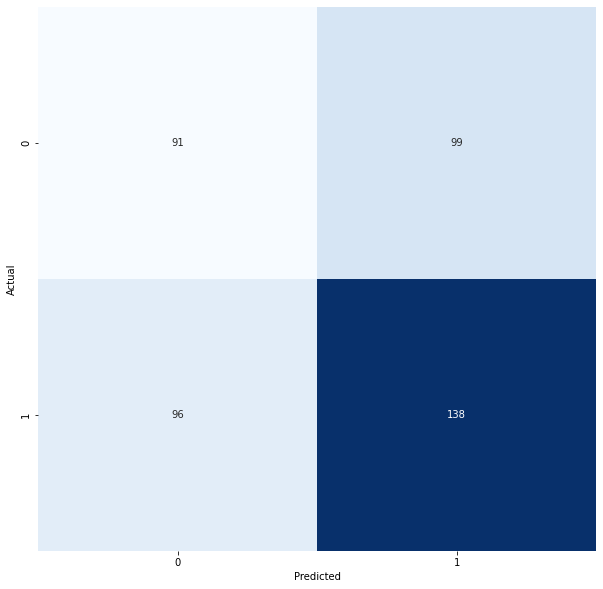

In [1102]:
cm = confusion_matrix(y_val, model_knn.predict(X_val))
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Final results

In [1103]:
print(f1_score(y_test, model_knn.predict(X_test)))
print(classification_report(y_test, model_knn.predict(X_test)))

0.5641025641025642
              precision    recall  f1-score   support

           0       0.25      0.15      0.19        13
           1       0.50      0.65      0.56        17

    accuracy                           0.43        30
   macro avg       0.38      0.40      0.38        30
weighted avg       0.39      0.43      0.40        30



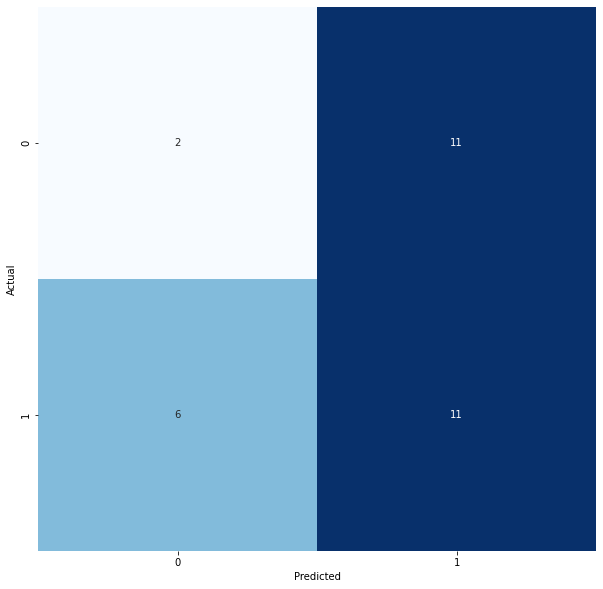

In [1104]:
cm = confusion_matrix(y_test, model_knn.predict(X_test))
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Naive Bayes

In [1013]:
from sklearn.naive_bayes import GaussianNB
model_nb = GaussianNB()

### CV evaluation

In [1014]:
model_nb.fit(X_train , y_train)
print(f1_score(y_val , model_nb.predict(X_val)))
print(classification_report(y_val , model_nb.predict(X_val)))
cm = confusion_matrix(y_val, model_nb.predict(X_val))
cm

0.016666666666666666
              precision    recall  f1-score   support

           0       0.44      0.98      0.61       190
           1       0.33      0.01      0.02       234

    accuracy                           0.44       424
   macro avg       0.39      0.49      0.31       424
weighted avg       0.38      0.44      0.28       424



array([[186,   4],
       [232,   2]], dtype=int64)

### Final results

In [1015]:
y_pred_nb_final = model_nb.predict(X_test)
print(f1_score(y_test , y_pred_nb_final))
print(classification_report(y_test , y_pred_nb_final))
cm = confusion_matrix(y_test, y_pred_nb_final)
cm

0.0
              precision    recall  f1-score   support

           0       0.43      1.00      0.60        13
           1       0.00      0.00      0.00        17

    accuracy                           0.43        30
   macro avg       0.22      0.50      0.30        30
weighted avg       0.19      0.43      0.26        30



array([[13,  0],
       [17,  0]], dtype=int64)

<font color="red">TODO ^ <br> hame score ha dakhel yek df bian  </font>


## Advanced Methods (Optional) : Neural Network

In [1016]:
import tensorflow as tf
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout , LSTM , LeakyReLU
from sklearn.utils.class_weight import compute_class_weight


In [1017]:
# class_weights = compute_class_weight('balanced', classes=[0, 1],y=y_train)
# class_weights

In [1092]:
model_NN = Sequential([
    # LSTM(12, input_shape=(5, 12), activation='relu'),
    # Dense(64, activation='relu'),
    # Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    # Dense(32, activation=LeakyReLU(alpha=0.1)),
    Dense(1, activation='sigmoid')
])
model_NN.compile(optimizer='adam', loss='binary_crossentropy', metrics=[recall , precision])
model_NN.fit(X_train, y_train, epochs=15 , validation_data=(X_val, y_val) )

Epoch 1/15


53/53 [==============================] - 1s 8ms/step - loss: 0.7049 - recall_11: 0.5852 - precision_11: 0.5368 - val_loss: 0.6952 - val_recall_11: 0.5000 - val_precision_11: 0.5467
Epoch 2/15
53/53 [==============================] - 0s 3ms/step - loss: 0.6958 - recall_11: 0.6526 - precision_11: 0.5282 - val_loss: 0.6914 - val_recall_11: 0.6709 - val_precision_11: 0.5528
Epoch 3/15
53/53 [==============================] - 0s 3ms/step - loss: 0.6965 - recall_11: 0.6537 - precision_11: 0.5158 - val_loss: 0.6915 - val_recall_11: 0.6239 - val_precision_11: 0.5468
Epoch 4/15
53/53 [==============================] - 0s 3ms/step - loss: 0.6936 - recall_11: 0.6400 - precision_11: 0.5344 - val_loss: 0.6902 - val_recall_11: 0.7436 - val_precision_11: 0.5577
Epoch 5/15
53/53 [==============================] - 0s 3ms/step - loss: 0.6944 - recall_11: 0.6503 - precision_11: 0.5333 - val_loss: 0.6905 - val_recall_11: 0.6838 - val_precision_11: 0.5536
Epoch 6/15
53/53 [==============================] -

In [1093]:
y_pred_nn = model_NN.predict(X_val)
y_pred_nn = np.round(y_pred_nn)
# print(y_pred_nn)
print(f1_score(y_val, y_pred_nn))

14/14 [==============================] - 0s 2ms/step
0.6560283687943262


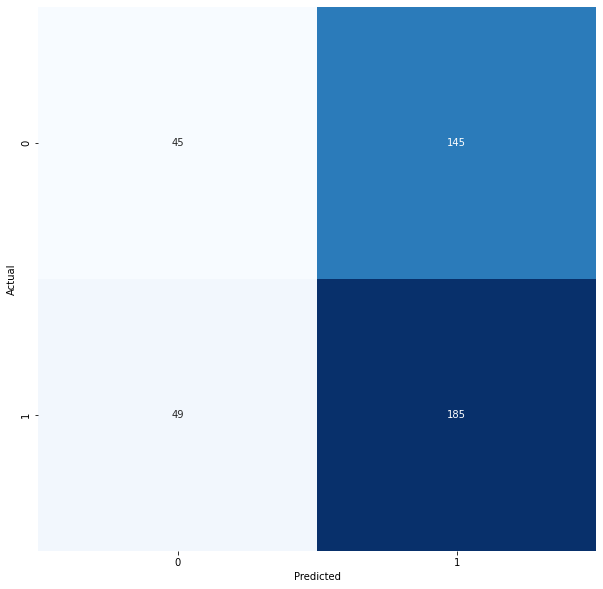

In [1094]:
# plot the confusion matrix
cm = confusion_matrix(y_val, y_pred_nn)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() 


In [1095]:
y_pred_nn_final = model_NN.predict(X_test)
y_pred_nn_final = np.round(y_pred_nn_final)

1/1 [==============================] - 0s 27ms/step


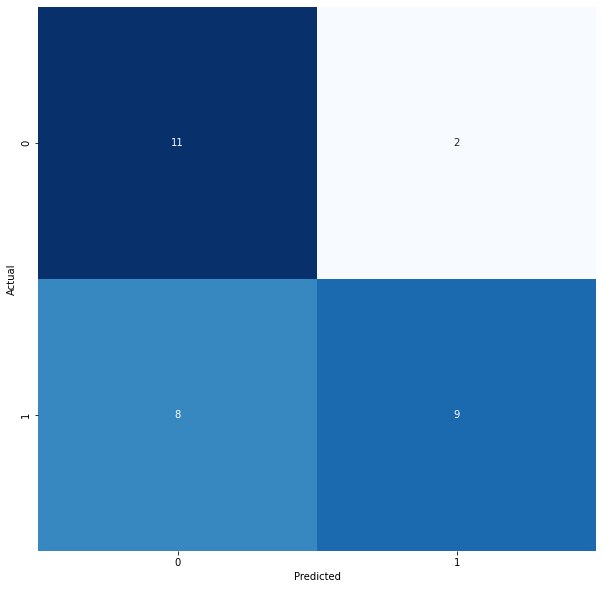

In [1096]:
cm = confusion_matrix(y_test, y_pred_nn_final)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() 


In [1097]:
print(f1_score(y_test, y_pred_nn_final))

0.6428571428571428
